# Stade Rennais Technical Interview
Data Scientist

## Libraries and Data Imports

In [647]:
import pandas as pd
import seaborn as sb
from scipy.stats import zscore
import warnings
warnings.filterwarnings("ignore")

In [614]:
df = pd.read_excel('Fichier Technique.xlsx')
df.head()

,player_id,team_id,player_season_np_xg_per_shot,player_season_np_xg_90,player_season_np_shots_90,player_season_goals_90,player_season_npga_90,player_season_xa_90,player_season_key_passes_90,player_season_op_key_passes_90,...,player_season_f3_lbp_to_space_10_90,player_season_lbp_to_space_2_90,player_season_fhalf_lbp_to_space_2_90,player_season_f3_lbp_to_space_2_90,player_season_lbp_to_space_5_90,player_season_fhalf_lbp_to_space_5_90,player_season_f3_lbp_to_space_5_90,player_season_360_minutes,preferred_foot,Age
0,3253,133,0.052712,0.025327,0.480484,0.000000,0.053387,0.005878,0.106774,0.106774,...,0.053387,3.310001,0.640645,0.160161,1.655001,0.320323,0.106774,1685.7999,Right-Foot,37.85
1,2989,138,0.085397,0.042528,0.498006,0.031125,0.062251,0.019141,0.311254,0.311254,...,0.000000,3.672792,0.996011,0.124501,1.338390,0.373504,0.000000,2891.5337,Right-Foot,29.22
2,3143,144,0.055486,0.040305,0.726403,0.026904,0.026904,0.016698,0.269038,0.269038,...,0.000000,2.959420,0.914730,0.134519,1.479710,0.457365,0.026904,3345.2500,Right-Foot,31.70
3,2952,133,0.078340,0.034931,0.445886,0.031849,0.031849,0.010461,0.159245,0.159245,...,0.000000,3.567090,0.541433,0.063698,1.656149,0.350339,0.063698,2825.8333,Right-Foot,30.94
4,2973,153,0.036059,0.008499,0.235705,0.000000,0.000000,0.005036,0.157137,0.157137,...,0.000000,2.749891,0.235705,0.000000,1.492798,0.000000,0.000000,1145.5000,Right-Foot,31.19


## Data Cleaning

In [615]:
players_df = df.copy()

# Drop single-valued columns as they do not offer any useful info
single_val_cols = [c for c in players_df.columns if players_df[c].nunique() < 2]
players_df.drop(single_val_cols, axis=1, inplace=True)

# Remove prefix "player_season" from column names for readability
players_df.columns = players_df.columns.str.replace(r'player_season_', '')
players_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Columns: 190 entries, player_id to Age
dtypes: float64(183), int64(4), object(3)
memory usage: 147.1+ KB


## Feature Selection and Model creation
### AMRSS
My rating model is going to use the following features from the provided 209 columns. Of course, all the decisions I will make from now on are based on the hypothesis that we are going to try find a replacement for right-centre-back that just left our team. I will make the assumption that the starting player 23-year old Warmed Omari left the club and we need a similar replacement to cover his spot. 

It is also important to note that all the metrics I use and how I weighted them are my interpretation of what I think is right. This might not be what you think is important and it might not be what the head of recruitment thinks is important. As I was not provided with a "desired profile" I will base it on my interpretation of the game and Warmed Omari playing style. (I got a notion from watching 3-4 games and looking at his data from the last year on FBRef)

I am going to define 3 different types/profiles of centre backs according to my understanding of the game and compute a weighted average to find the perfect CB. Each type will be made up of some weights applied to statistical categories (e.g. aerial dominance, one v one defending, ...). Each category is going to be made up of different statistics. Each statistic is going to be assigned a weight/importance that is going to determine its impact on that category. (I am basing this work on my own interpretation of Edd Webster's Role Scouting System)

Summing up: Chosen CB -> 3 profiles -> 12 categories -> 64 features

In [616]:
# Player personal information
general = ['player_id', 'team_id', 'Age', 'secondary_position', 'preferred_foot', 'left_foot_ratio']

# Player season playing time information
playing_time = ['appearances', 'Titularisations', '90s_played', 'average_minutes', 'most_recent_match']

# Defensive stats
aerial_dominance = ['aerial_ratio', 'aerial_wins_90'] 
aggression = ['aggressive_actions_90', 'fouls_90', 'yellow_cards_90', 'second_yellow_cards_90', 'red_cards_90'] 
decisions_off_ball = ['pressure_regains_90', 'padj_pressures_90', 'counterpressure_regains_90', 'counterpressures_90',] 
interceptions = ['padj_interceptions_90', 'padj_clearances_90', 'ball_recoveries_90', 'fhalf_ball_recoveries_90', 'defensive_action_regains_90', 
             'obv_defensive_action_90'] 
one_v_one_defending = ['dribble_faced_ratio', 'padj_tackles_90', 'challenge_ratio', 'blocks_per_shot']

# In-possesion stats
decisions_on_ball = ['lbp_pass_ratio', 'fhalf_lbp_pass_ratio', 'pass_into_pressure_ratio', 'pass_into_danger_ratio'] 
progressive_passing = ['passing_ratio', 'long_ball_ratio', 'long_balls_90', 'forward_pass_proportion', 'op_f3_passes_90', 
                       'op_f3_forward_pass_proportion', 'deep_completions_90']
progressive_carries = ['carries_90', 'carry_ratio', 'dribbles_90', 'total_dribbles_90', 'deep_progressions_90', 'obv_dribble_carry_90']
buildup = ['op_xgbuildup_90', 'op_xgbuildup_per_possession']
pass_delivery = ['pressured_passing_ratio', 'pressured_long_balls_90', 'unpressured_long_balls_90', 'lbp_ratio', 'lbp_90']

# Offensive stats
quality_touches = ['key_passes_90', 'through_balls_90', 'op_passes_into_box_90', 'positive_outcome_90',]
offensive_threat = ['goals_90', 'conversion_ratio', 'assists_90', 'xgchain_per_possession']

In [617]:
# We select all the different stats we will use for the 3 types of centre-backs defined and flatten the list
selected_stats = [general, playing_time, aerial_dominance, aggression, decisions_off_ball, interceptions, one_v_one_defending, 
                  decisions_on_ball, progressive_passing, progressive_carries, buildup, pass_delivery, quality_touches, offensive_threat]

selected_stats = [stat for category in selected_stats for stat in category]

# In total we have 63 different features that will help us decide for all 3 types (we do not use all for each type)
final_players_df = players_df[selected_stats]
final_players_df.head()

,player_id,team_id,Age,secondary_position,preferred_foot,left_foot_ratio,appearances,Titularisations,90s_played,average_minutes,...,lbp_ratio,lbp_90,key_passes_90,through_balls_90,op_passes_into_box_90,positive_outcome_90,goals_90,conversion_ratio,assists_90,xgchain_per_possession
0,3253,133,37.85,Right Centre Back,Right-Foot,0.103448,20,18,18.731110,84.289990,...,0.637584,7.954681,0.106774,0.000000,0.106774,2.583937,0.000000,0.000000,0.053387,0.008747
1,2989,138,29.22,Left Centre Back,Right-Foot,0.178145,31,31,32.128150,93.275280,...,0.571429,10.675995,0.311254,0.062251,0.404630,3.215249,0.031125,0.062500,0.031125,0.009264
2,3143,144,31.70,Left Centre Back,Right-Foot,0.082723,36,36,37.169445,92.923615,...,0.518868,8.555414,0.269038,0.026904,0.107615,3.040131,0.026904,0.037037,0.000000,0.008748
3,2952,133,30.94,Right Centre Back,Right-Foot,0.155615,32,31,31.398148,88.307290,...,0.530686,8.822176,0.159245,0.000000,0.095547,2.837748,0.031849,0.071429,0.000000,0.009190
4,2973,153,31.19,Right Centre Back,Right-Foot,0.109827,16,12,12.727778,71.593750,...,0.650794,4.949803,0.157137,0.000000,0.157137,2.254910,0.000000,0.000000,0.000000,0.005861


In [618]:
# We search for columns with null values
final_players_df[final_players_df.columns[final_players_df.isna().any()].tolist()].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   secondary_position             80 non-null     object 
 1   aerial_ratio                   96 non-null     float64
 2   obv_defensive_action_90        97 non-null     float64
 3   dribble_faced_ratio            89 non-null     float64
 4   challenge_ratio                95 non-null     float64
 5   blocks_per_shot                98 non-null     float64
 6   fhalf_lbp_pass_ratio           97 non-null     float64
 7   long_ball_ratio                97 non-null     float64
 8   op_f3_forward_pass_proportion  94 non-null     float64
 9   pressured_passing_ratio        97 non-null     float64
 10  lbp_ratio                      97 non-null     float64
 11  positive_outcome_90            95 non-null     float64
 12  conversion_ratio               85 non-null     float

In [619]:
# We fill nulls with according values. 
# Missing numerical values come generally from ratio columns, in cases such: 0 shots -> conversion = null (because no shot was done). 
# It makes sense to assign 0 to all those columns
final_players_df['secondary_position'] = final_players_df['secondary_position'].fillna('')
final_players_df = final_players_df.fillna(0)

Here I make the decision to select only players with a certain amount of minutes played and some other conditions that the players must comply with to be considered.

Since we are looking for a right-CB it makes more sense to look for right-footed CB. However, there can be really good left-footed CB that can also play on the right. However, I put a threshold on at least 30% of time playing with right foot as they need to be also good with it nad be able to perform.

By looking into the squad's characteristics and club's mentality regarding player selection, it is easy to see they like young players that can quickly perform at the top level. It is a very young squad with an average of 24.6 years (Transfermarkt) but it is even younger for centre-backs with 6 players averaging less than 21 years.

It is also seen that multiple players are coming directly from the club's academy or young players that are signed at an early stage of their career which atfer "booming" can be sold for hight prices: Dembélé, Camavinga, Doku, Ugochukwu, Sarr, Badé are really good examples of this. For this reason I think it makes sense to look into younger players that can be developed or starting to become important players rather than players towards the end of their career. Nevertheless, I want to keep more experienced players as an open option. Some older players could still become important and can give an extra boost with their experience while also assisting the younger players and guiding them to become even better at a faster rate. (Nemanja Matic is an example of this, a player with a lot of experience that is towards the end of its career but that can still have a lot of impact in the club)

In [620]:
# We define some necessary conditions 
final_players_df = final_players_df[
                                    (final_players_df['90s_played']>=8.0) & 
                                    (final_players_df['appearances']>=15.0) & 
                                    (final_players_df['left_foot_ratio']<=0.7) & 
                                    (final_players_df['Age']<=30.0)
                                    ]

In [621]:
# Next, we normalize the values between 0-100 for all columns to remove problems with different value ranges
dff = final_players_df.iloc[:,11:]
final_players_df.iloc[:,11:] = (dff - dff.min()) / (dff.max() - dff.min())*100
final_players_df.head()

,player_id,team_id,Age,secondary_position,preferred_foot,left_foot_ratio,appearances,Titularisations,90s_played,average_minutes,...,lbp_ratio,lbp_90,key_passes_90,through_balls_90,op_passes_into_box_90,positive_outcome_90,goals_90,conversion_ratio,assists_90,xgchain_per_possession
1,2989,138,29.22,Left Centre Back,Right-Foot,0.178145,31,31,32.128150,93.27528,...,47.043637,100.000000,36.136787,42.674294,59.478920,42.609171,19.842601,18.750000,41.131965,30.638325
5,3044,147,29.23,,Right-Foot,0.122614,36,32,33.809080,84.52269,...,51.094732,65.102814,13.736052,81.105209,100.000000,77.088153,94.280321,55.555556,0.000000,66.630480
9,4598,138,26.77,Right Centre Back,Right-Foot,0.176205,20,19,19.051851,85.73333,...,41.298839,74.318521,24.375755,0.000000,38.577876,45.291533,33.461636,21.428571,69.363025,50.929712
14,4372,131,29.46,Centre Back,Right-Foot,0.215323,33,30,32.110000,87.57272,...,98.951369,37.624764,32.541493,21.349209,13.733664,60.100570,39.707637,31.578947,0.000000,100.000000
24,6855,129,29.48,Right Centre Back,Right-Foot,0.069672,26,25,25.745186,89.11795,...,51.612416,42.067025,9.019225,0.000000,5.709649,41.426474,74.286441,56.250000,0.000000,35.170223


### Categories calculations
Now we add the calculations for each player for each category with the weighted values assigning the desired importance

In [622]:
# Defensive stats
final_players_df['aerial_dominance'] = (0.5 * final_players_df['aerial_ratio'] + 0.5 * final_players_df['aerial_wins_90'])
final_players_df['aggression'] = (0.3 * final_players_df['aggressive_actions_90'] + 0.3 * final_players_df['fouls_90'] +
                                  0.2 * final_players_df['yellow_cards_90'] + 0.1 * final_players_df['second_yellow_cards_90'] +
                                  0.1 * final_players_df['red_cards_90'])
final_players_df['decisions_off_ball'] = (0.3 * final_players_df['pressure_regains_90'] + 0.2 * final_players_df['padj_pressures_90'] +
                                          0.3 * final_players_df['counterpressure_regains_90'] + 0.2 * final_players_df['counterpressures_90'])
final_players_df['interceptions'] = (0.3 * final_players_df['padj_interceptions_90'] + 0.2 * final_players_df['padj_clearances_90'] +
                                     0.15 * final_players_df['ball_recoveries_90'] + 0.25 * final_players_df['fhalf_ball_recoveries_90'] +
                                     0.1 * final_players_df['defensive_action_regains_90'] + 0.1 * final_players_df['obv_defensive_action_90'])

final_players_df['one_v_one_defending'] = (0.3 * final_players_df['blocks_per_shot']+ 0.25 * final_players_df['dribble_faced_ratio'] +
                                           0.2 * final_players_df['padj_tackles_90'] + 0.25 * final_players_df['challenge_ratio'])


# In-possesion stats
final_players_df['decisions_on_ball'] = (0.3 * final_players_df['lbp_pass_ratio'] + 0.25 * final_players_df['fhalf_lbp_pass_ratio'] + 
                                         0.25 * final_players_df['pass_into_pressure_ratio'] + 0.2 * final_players_df['pass_into_danger_ratio'])
final_players_df['progressive_passing'] = (0.25 * final_players_df['passing_ratio'] + 0.1 * final_players_df['long_ball_ratio'] +
                                           0.05 * final_players_df['long_balls_90'] + 0.2 * final_players_df['forward_pass_proportion'] +
                                           0.15 * final_players_df['op_f3_passes_90'] + 0.1 * final_players_df['op_f3_forward_pass_proportion'] +
                                           0.15 * final_players_df['deep_completions_90'])
final_players_df['progressive_carries'] = (0.2 * final_players_df['carries_90'] + 0.2 * final_players_df['carry_ratio'] +
                                           0.15 * final_players_df['dribbles_90'] + 0.15 * final_players_df['total_dribbles_90'] +
                                           0.15 * final_players_df['deep_progressions_90'] + 0.15 * final_players_df['obv_dribble_carry_90'])
final_players_df['buildup'] = (0.7 * final_players_df['op_xgbuildup_90'] + 0.3 * final_players_df['op_xgbuildup_per_possession'])
final_players_df['pass_delivery'] =   (0.3 * final_players_df['pressured_passing_ratio'] + 0.2 * final_players_df['pressured_long_balls_90'] +
                                       0.1 * final_players_df['unpressured_long_balls_90'] + 0.2 * final_players_df['lbp_ratio'] + 
                                       0.2 * final_players_df['lbp_90'])

# Offensive stats
final_players_df['quality_touches'] = (0.3 * final_players_df['key_passes_90'] + 0.25 * final_players_df['through_balls_90'] +
                                       0.2 * final_players_df['op_passes_into_box_90'] + 0.25 * final_players_df['positive_outcome_90'])
final_players_df['offensive_threat'] = (0.4 * final_players_df['goals_90'] + 0.2 * final_players_df['conversion_ratio'] + 
                                        0.25 * final_players_df['assists_90'] + 0.15 * final_players_df['xgchain_per_possession'])

### Top 10 rated players by CB profile qualities

Once we have assigned the features and importances for each statistics category we can finally group it to find the final score for each centre back profile we have defined. We then will show the top 10 players by each type.

In [623]:
final_players_df['stopper_cb'] = (0.12 * final_players_df['aerial_dominance'] + 0.1 * final_players_df['aggression'] +
                                  0.18 * final_players_df['decisions_off_ball'] + 0.2 * final_players_df['interceptions'] +
                                  0.2 * final_players_df['one_v_one_defending'] + 0.05 * final_players_df['offensive_threat'] +
                                  0.05 * final_players_df['buildup'] + 0.1 * final_players_df['pass_delivery'])

final_players_df['ball_playing_cb'] = (0.1 * final_players_df['aerial_dominance'] + 0.05 * final_players_df['quality_touches'] +
                                       0.1 * final_players_df['decisions_off_ball'] + 0.15 * final_players_df['decisions_on_ball'] +
                                       0.15 * final_players_df['one_v_one_defending'] + 0.05 * final_players_df['offensive_threat'] +
                                       0.1 * final_players_df['buildup'] + 0.1 * final_players_df['pass_delivery'] + 
                                       0.2 * final_players_df['progressive_passing'])


final_players_df['ball_carrying_cb'] = (0.1 * final_players_df['aerial_dominance'] + 0.18 * final_players_df['decisions_on_ball'] +
                                        0.1 * final_players_df['decisions_off_ball'] + 0.2 * final_players_df['progressive_carries'] +
                                        0.15 * final_players_df['one_v_one_defending'] + 0.05 * final_players_df['offensive_threat'] +
                                        0.1 * final_players_df['buildup'] + 0.12 * final_players_df['pass_delivery'])

In [624]:
base = [general, playing_time]
base = [stat for category in base for stat in category] # We flatten the list

# Categories for each profile
stopper_cb = ['aerial_dominance', 'aggression', 'decisions_off_ball', 'interceptions', 'one_v_one_defending', 
           'offensive_threat', 'buildup', 'pass_delivery','stopper_cb']

ball_playing_cb = ['aerial_dominance', 'decisions_off_ball', 'one_v_one_defending', 'decisions_on_ball', 
                   'pass_delivery', 'buildup', 'progressive_passing', 'quality_touches', 'offensive_threat', 'ball_playing_cb']

ball_carrying_cb = ['aerial_dominance', 'decisions_off_ball', 'one_v_one_defending',  
                    'decisions_on_ball', 'pass_delivery', 'buildup', 'progressive_carries', 'offensive_threat', 'ball_carrying_cb']

# We add the profile score to df
stopper_cb_df = final_players_df[base].join(final_players_df[stopper_cb])
ball_playing_cb_df = final_players_df[base].join(final_players_df[ball_playing_cb])
ball_carrying_cb_df = final_players_df[base].join(final_players_df[ball_carrying_cb])

#### Top 10 Stoppers

In [625]:
stopper_cb_df.sort_values('stopper_cb', ascending=False).head(10)

,player_id,team_id,Age,secondary_position,preferred_foot,left_foot_ratio,appearances,Titularisations,90s_played,average_minutes,most_recent_match,aerial_dominance,aggression,decisions_off_ball,interceptions,one_v_one_defending,offensive_threat,buildup,pass_delivery,stopper_cb
66,33233,147,24.76,Left Centre Back,Right-Foot,0.122780,35,30,31.331673,80.567160,2023-06-03T22:00,66.788703,66.470483,82.158070,96.401836,76.398144,17.206140,56.403660,50.813225,72.771954
68,39018,137,22.55,Right Back,Right-Foot,0.087554,24,22,23.295000,87.356255,2023-05-19T22:00,74.437518,38.462552,71.983684,84.465865,57.761098,5.718675,39.125186,56.270616,62.050468
1,2989,138,29.22,Left Centre Back,Right-Foot,0.178145,31,31,32.128150,93.275280,2023-05-21T16:00,94.736387,49.448466,52.194111,82.713632,46.103516,26.565781,35.699519,66.934841,61.278332
56,23331,139,26.54,Right Centre Back,Right-Foot,0.359914,15,15,14.956112,89.736670,2023-05-27T22:00,100.000000,69.942654,67.083082,69.459547,44.947356,5.568369,42.278651,43.362189,60.679171
45,11532,136,23.83,Centre Back,Right-Foot,0.080490,34,33,33.901300,89.738720,2023-05-27T22:00,36.894927,38.501749,80.190828,63.477714,79.882765,4.513928,39.469345,68.105254,60.393700
83,49705,156,26.37,Centre Back,Right-Foot,0.124076,29,27,28.429630,88.229890,2023-05-27T22:00,48.536949,52.261440,64.164955,77.899879,56.044218,18.879836,50.452761,70.545351,59.910254
90,132796,143,24.22,,No-Preference,0.542435,21,16,19.125183,81.965070,2023-06-03T22:00,30.169435,33.077479,46.813074,85.348960,49.013517,61.347954,78.514510,72.756492,56.495701
46,11820,168,25.11,Right Centre Back,Right-Foot,0.132899,37,37,38.444820,93.514430,2023-06-03T22:00,73.233136,30.605399,38.237701,68.732563,50.675090,27.353564,68.496461,66.186534,54.023987
24,6855,129,29.48,Right Centre Back,Right-Foot,0.069672,26,25,25.745186,89.117950,2023-06-03T22:00,54.067328,48.289621,49.634192,52.477114,64.522705,46.240110,25.014530,54.914146,52.705306
9,4598,138,26.77,Right Centre Back,Right-Foot,0.176205,20,19,19.051851,85.733330,2023-06-03T22:00,41.007333,68.256812,71.748037,44.569945,46.970857,42.650582,50.855626,49.577349,52.602413


#### Top 10 Ball-playing CBs

In [626]:
ball_playing_cb_df.sort_values('ball_playing_cb', ascending=False).head(10)

,player_id,team_id,Age,secondary_position,preferred_foot,left_foot_ratio,appearances,Titularisations,90s_played,average_minutes,...,aerial_dominance,decisions_off_ball,one_v_one_defending,decisions_on_ball,pass_delivery,buildup,progressive_passing,quality_touches,offensive_threat,ball_playing_cb
1,2989,138,29.22,Left Centre Back,Right-Foot,0.178145,31,31,32.128150,93.275280,...,94.736387,52.194111,46.103516,61.350366,66.934841,35.699519,51.327116,44.057686,26.565781,54.871165
37,7439,129,25.64,Right Back,Right-Foot,0.086050,38,37,39.644817,93.895620,...,87.889716,29.487978,61.319026,46.901743,50.334587,47.277834,58.232460,45.087238,59.292230,54.597592
83,49705,156,26.37,Centre Back,Right-Foot,0.124076,29,27,28.429630,88.229890,...,48.536949,64.164955,56.044218,50.781797,70.545351,50.452761,47.205003,66.626831,18.879836,53.110238
68,39018,137,22.55,Right Back,Right-Foot,0.087554,24,22,23.295000,87.356255,...,74.437518,71.983684,57.761098,37.958598,56.270616,39.125186,57.875314,29.641195,5.718675,51.882711
5,3044,147,29.23,,Right-Foot,0.122614,36,32,33.809080,84.522690,...,58.261130,39.981861,47.708749,44.009257,50.724696,66.227010,45.347286,63.669156,58.817812,50.470976
45,11532,136,23.83,Centre Back,Right-Foot,0.080490,34,33,33.901300,89.738720,...,36.894927,80.190828,79.882765,25.764075,68.105254,39.469345,51.114079,29.387983,4.513928,50.230973
66,33233,147,24.76,Left Centre Back,Right-Foot,0.122780,35,30,31.331673,80.567160,...,66.788703,82.158070,76.398144,24.461198,50.813225,56.403660,36.705716,14.742467,17.206140,49.683841
90,132796,143,24.22,,No-Preference,0.542435,21,16,19.125183,81.965070,...,30.169435,46.813074,49.013517,30.776629,72.756492,78.514510,49.398433,17.641775,61.347954,48.623046
14,4372,131,29.46,Centre Back,Right-Foot,0.215323,33,30,32.110000,87.572720,...,18.692980,38.457962,71.005315,3.986232,62.608805,98.680971,59.924284,32.871626,37.198844,48.581184
46,11820,168,25.11,Right Centre Back,Right-Foot,0.132899,37,37,38.444820,93.514430,...,73.233136,38.237701,50.675090,25.287913,66.186534,68.496461,42.634925,35.261600,27.353564,47.667577


#### Top 10 Ball-carrying CBs

In [627]:
ball_carrying_cb_df.sort_values('ball_carrying_cb', ascending=False).head(10)

,player_id,team_id,Age,secondary_position,preferred_foot,left_foot_ratio,appearances,Titularisations,90s_played,average_minutes,most_recent_match,aerial_dominance,decisions_off_ball,one_v_one_defending,decisions_on_ball,pass_delivery,buildup,progressive_carries,offensive_threat,ball_carrying_cb
37,7439,129,25.64,Right Back,Right-Foot,0.086050,38,37,39.644817,93.895620,2023-06-03T22:00,87.889716,29.487978,61.319026,46.901743,50.334587,47.277834,60.157161,59.292230,55.141915
45,11532,136,23.83,Centre Back,Right-Foot,0.080490,34,33,33.901300,89.738720,2023-05-27T22:00,36.894927,80.190828,79.882765,25.764075,68.105254,39.469345,70.936402,4.513928,54.861066
46,11820,168,25.11,Right Centre Back,Right-Foot,0.132899,37,37,38.444820,93.514430,2023-06-03T22:00,73.233136,38.237701,50.675090,25.287913,66.186534,68.496461,74.882214,27.353564,54.436322
68,39018,137,22.55,Right Back,Right-Foot,0.087554,24,22,23.295000,87.356255,2023-05-19T22:00,74.437518,71.983684,57.761098,37.958598,56.270616,39.125186,65.496211,5.718675,54.189001
83,49705,156,26.37,Centre Back,Right-Foot,0.124076,29,27,28.429630,88.229890,2023-05-27T22:00,48.536949,64.164955,56.044218,50.781797,70.545351,50.452761,54.057378,18.879836,54.083732
66,33233,147,24.76,Left Centre Back,Right-Foot,0.122780,35,30,31.331673,80.567160,2023-06-03T22:00,66.788703,82.158070,76.398144,24.461198,50.813225,56.403660,51.077715,17.206140,53.571218
90,132796,143,24.22,,No-Preference,0.542435,21,16,19.125183,81.965070,2023-06-03T22:00,30.169435,46.813074,49.013517,30.776629,72.756492,78.514510,65.979574,61.347954,53.435614
51,22117,145,24.68,Right Back,Right-Foot,0.039490,30,30,29.372963,88.118890,2023-06-03T22:00,25.368281,73.519786,58.527108,80.788709,42.469881,14.222234,63.651771,2.777416,52.597675
5,3044,147,29.23,,Right-Foot,0.122614,36,32,33.809080,84.522690,2023-06-03T22:00,58.261130,39.981861,47.708749,44.009257,50.724696,66.227010,57.898880,58.817812,52.132609
1,2989,138,29.22,Left Centre Back,Right-Foot,0.178145,31,31,32.128150,93.275280,2023-05-21T16:00,94.736387,52.194111,46.103516,61.350366,66.934841,35.699519,32.647884,26.565781,52.111642


### Top 10 Overall
Now that we have the top 10 players for each profile type we are going to make a weighted average (according to my assigned importance) to find overall which are the best centre backs for our team. As I have mentioned, I highly value a ball-playing CB and therefore I assign it the highest weight.

In [628]:
scores_cb = final_players_df[base].join(final_players_df[['stopper_cb', 'ball_playing_cb', 'ball_carrying_cb']])
scores_cb['overall_cb'] = (0.25 * final_players_df['stopper_cb'] + 0.4 * final_players_df['ball_playing_cb'] + 0.35 * final_players_df['ball_carrying_cb'])
final_10 = scores_cb.sort_values('overall_cb', ascending=False).head(10)
final_10

,player_id,team_id,Age,secondary_position,preferred_foot,left_foot_ratio,appearances,Titularisations,90s_played,average_minutes,most_recent_match,stopper_cb,ball_playing_cb,ball_carrying_cb,overall_cb
66,33233,147,24.76,Left Centre Back,Right-Foot,0.122780,35,30,31.331673,80.567160,2023-06-03T22:00,72.771954,49.683841,53.571218,56.816451
1,2989,138,29.22,Left Centre Back,Right-Foot,0.178145,31,31,32.128150,93.275280,2023-05-21T16:00,61.278332,54.871165,52.111642,55.507123
68,39018,137,22.55,Right Back,Right-Foot,0.087554,24,22,23.295000,87.356255,2023-05-19T22:00,62.050468,51.882711,54.189001,55.231852
83,49705,156,26.37,Centre Back,Right-Foot,0.124076,29,27,28.429630,88.229890,2023-05-27T22:00,59.910254,53.110238,54.083732,55.150965
45,11532,136,23.83,Centre Back,Right-Foot,0.080490,34,33,33.901300,89.738720,2023-05-27T22:00,60.393700,50.230973,54.861066,54.392187
37,7439,129,25.64,Right Back,Right-Foot,0.086050,38,37,39.644817,93.895620,2023-06-03T22:00,51.636892,54.597592,55.141915,54.047930
90,132796,143,24.22,,No-Preference,0.542435,21,16,19.125183,81.965070,2023-06-03T22:00,56.495701,48.623046,53.435614,52.275609
46,11820,168,25.11,Right Centre Back,Right-Foot,0.132899,37,37,38.444820,93.514430,2023-06-03T22:00,54.023987,47.667577,54.436322,51.625740
5,3044,147,29.23,,Right-Foot,0.122614,36,32,33.809080,84.522690,2023-06-03T22:00,49.989914,50.470976,52.132609,50.932282
56,23331,139,26.54,Right Centre Back,Right-Foot,0.359914,15,15,14.956112,89.736670,2023-05-27T22:00,60.679171,46.925267,46.797103,50.318886


### Top 5 and Chosen player
By looking at the final scores and general player information I choose the TOP 5 players and rank them in order.

In [629]:
final_5 = final_10.iloc[0:6,].drop(45)
final_5['final_position'] = [3,2,1,4,5]
final_5 = final_5.sort_values('final_position')
final_5

,player_id,team_id,Age,secondary_position,preferred_foot,left_foot_ratio,appearances,Titularisations,90s_played,average_minutes,most_recent_match,stopper_cb,ball_playing_cb,ball_carrying_cb,overall_cb,final_position
68,39018,137,22.55,Right Back,Right-Foot,0.087554,24,22,23.295000,87.356255,2023-05-19T22:00,62.050468,51.882711,54.189001,55.231852,1
1,2989,138,29.22,Left Centre Back,Right-Foot,0.178145,31,31,32.128150,93.275280,2023-05-21T16:00,61.278332,54.871165,52.111642,55.507123,2
66,33233,147,24.76,Left Centre Back,Right-Foot,0.122780,35,30,31.331673,80.567160,2023-06-03T22:00,72.771954,49.683841,53.571218,56.816451,3
83,49705,156,26.37,Centre Back,Right-Foot,0.124076,29,27,28.429630,88.229890,2023-05-27T22:00,59.910254,53.110238,54.083732,55.150965,4
37,7439,129,25.64,Right Back,Right-Foot,0.086050,38,37,39.644817,93.895620,2023-06-03T22:00,51.636892,54.597592,55.141915,54.047930,5


The first player is the youngest of them, has a great projection, great scores in all CB profiles defined and is getting enough playing time to be considered. It is the best option to keep pushing youngsters into the team and develop great talent. I consider this to be important to maintain what the club has been working on and I also believe this player can reach a very high level if he's developed properly.

The second player is the oldest and that does not fit that much with the club's transfer philosophy but I think it could be a great opportunity to bring someone with a good amount of experience and can have a quick impact on the team while also guiding and help develop new talents.

The third player is overall the best ranked player by our scores. He is young but already has a good amount of experience. Nevertheless, it is the worst as a ball_playing_cb which is our desired CB profile. It is nonetheless, a great option to bring someone if a different player profile is desired.

The fourth player does not really shine on something specific but has really good overall value. It is probably in his peak in terms of physicallity but his qualities may not be expected to improve as he is already a well-established player.

The fifth player, has again a good profile although it may lack on the stopper profile. However, by looking at his time played it can be seen it is a player that can be trusted to be important during the whole season and get few injuries. 

## Results Visualisation

In [667]:
all_scores_cb = final_players_df.copy()
all_scores_cb['overall_cb'] = (0.25 * final_players_df['stopper_cb'] + 0.4 * final_players_df['ball_playing_cb'] + 0.35 * final_players_df['ball_carrying_cb'])
all_final_10 = all_scores_cb.sort_values('overall_cb', ascending=False).head(10)
all_final_5 = all_final_10.iloc[0:6,].drop(45)
all_final_5['final_position'] = [3,2,1,4,5]
all_final_5 = all_final_5.sort_values('final_position').reset_index(drop=True)
all_final_5.index = all_final_5.index+1
all_final_5

,player_id,team_id,Age,secondary_position,preferred_foot,left_foot_ratio,appearances,Titularisations,90s_played,average_minutes,...,progressive_carries,buildup,pass_delivery,quality_touches,offensive_threat,stopper_cb,ball_playing_cb,ball_carrying_cb,overall_cb,final_position
1,39018,137,22.55,Right Back,Right-Foot,0.087554,24,22,23.295000,87.356255,...,65.496211,39.125186,56.270616,29.641195,5.718675,62.050468,51.882711,54.189001,55.231852,1
2,2989,138,29.22,Left Centre Back,Right-Foot,0.178145,31,31,32.128150,93.275280,...,32.647884,35.699519,66.934841,44.057686,26.565781,61.278332,54.871165,52.111642,55.507123,2
3,33233,147,24.76,Left Centre Back,Right-Foot,0.122780,35,30,31.331673,80.567160,...,51.077715,56.403660,50.813225,14.742467,17.206140,72.771954,49.683841,53.571218,56.816451,3
4,49705,156,26.37,Centre Back,Right-Foot,0.124076,29,27,28.429630,88.229890,...,54.057378,50.452761,70.545351,66.626831,18.879836,59.910254,53.110238,54.083732,55.150965,4
5,7439,129,25.64,Right Back,Right-Foot,0.086050,38,37,39.644817,93.895620,...,60.157161,47.277834,50.334587,45.087238,59.292230,51.636892,54.597592,55.141915,54.047930,5


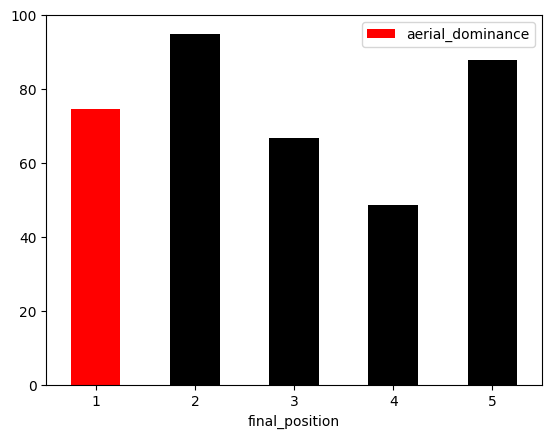

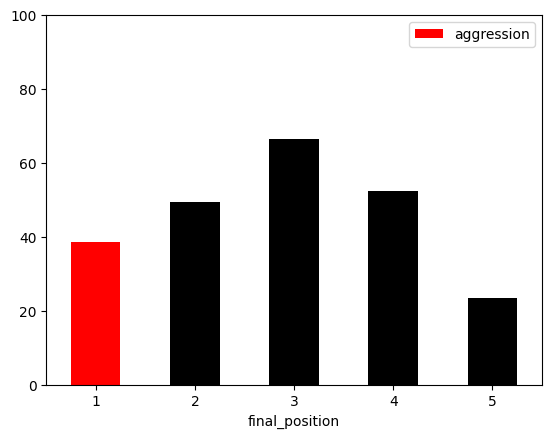

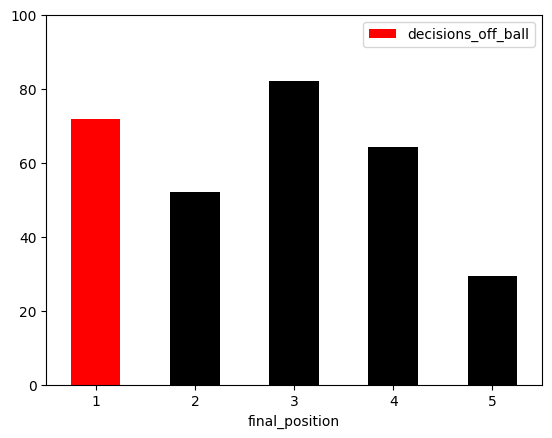

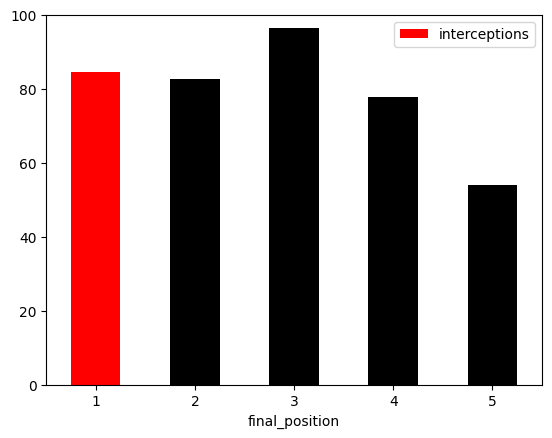

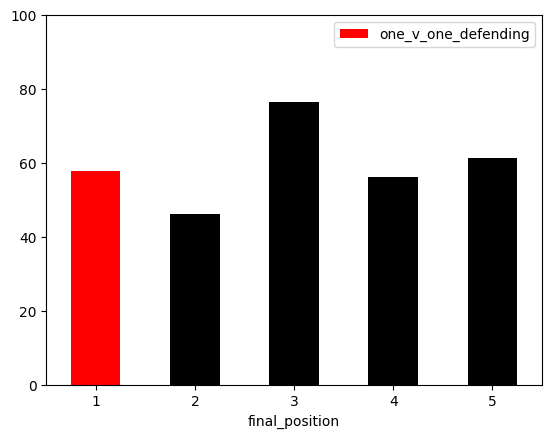

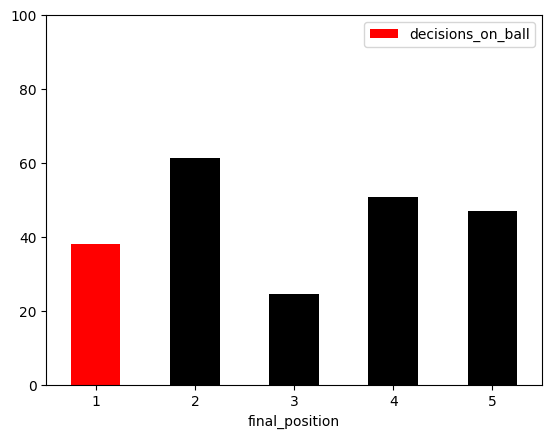

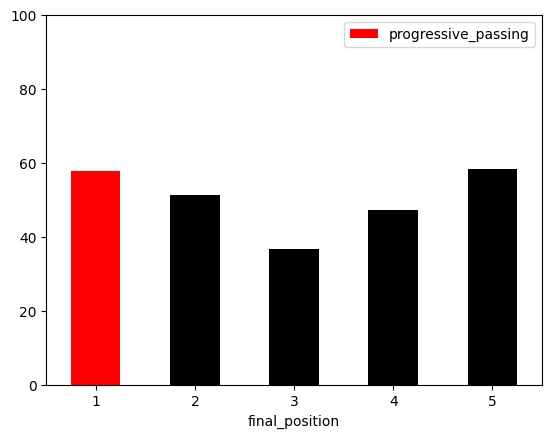

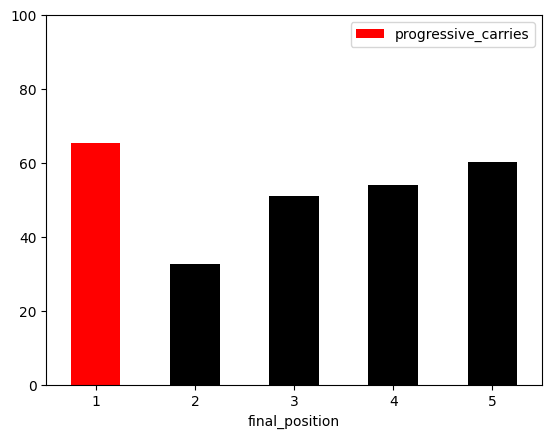

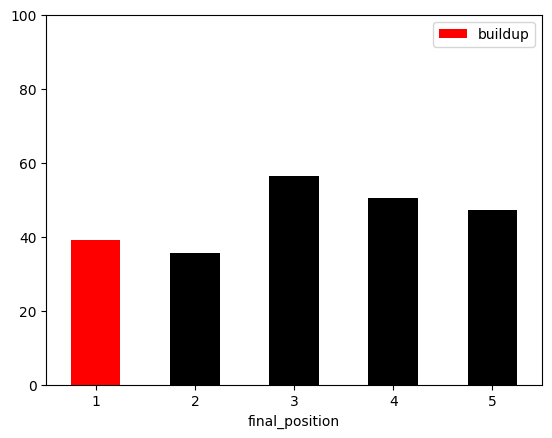

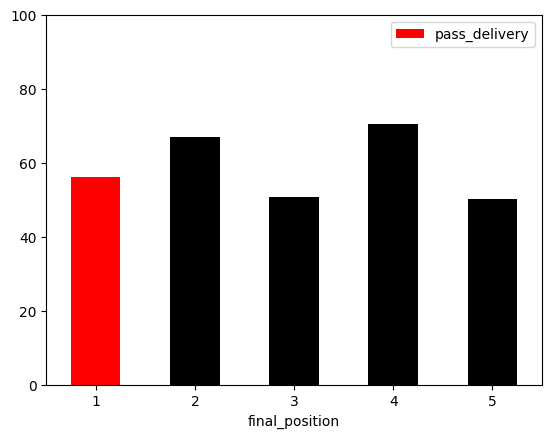

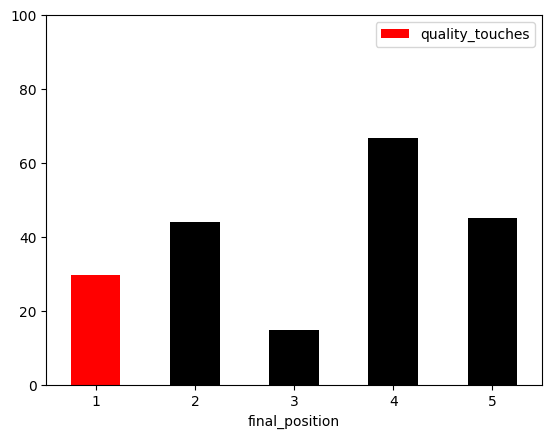

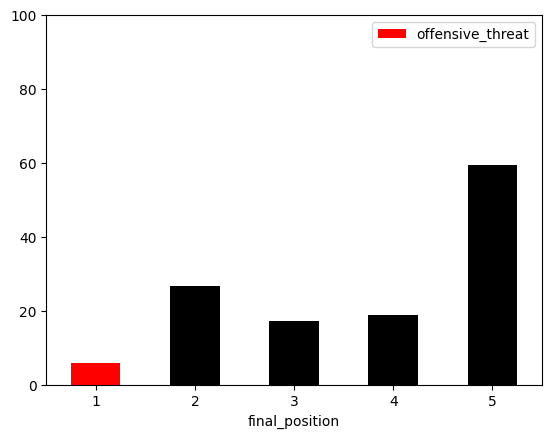

In [678]:
# Select only categories scores
categories_scores = all_final_5.iloc[:,64:-5].join(all_final_5['final_position'])
for col in categories_scores.iloc[:,:-1].columns:
    categories_scores.plot.bar(x='final_position', y=col, rot=0, color=['r','k','k','k','k']).set_ylim([0, 100])

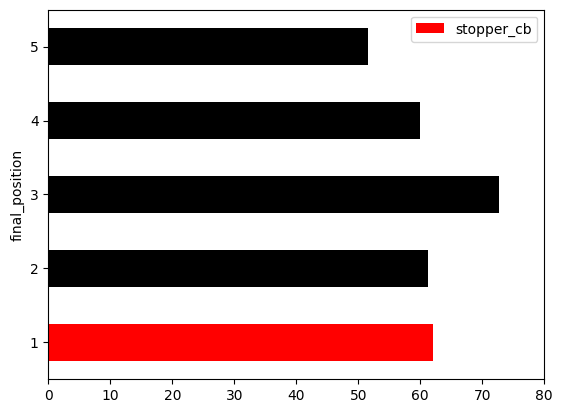

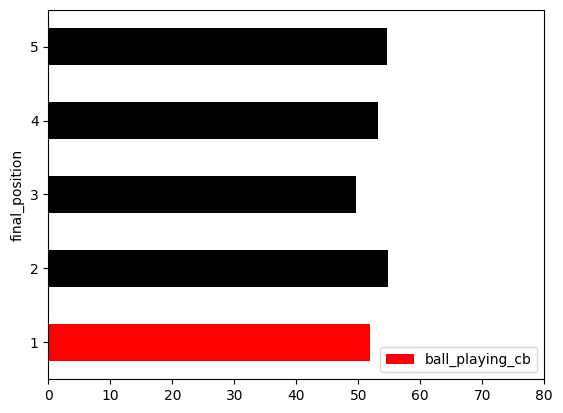

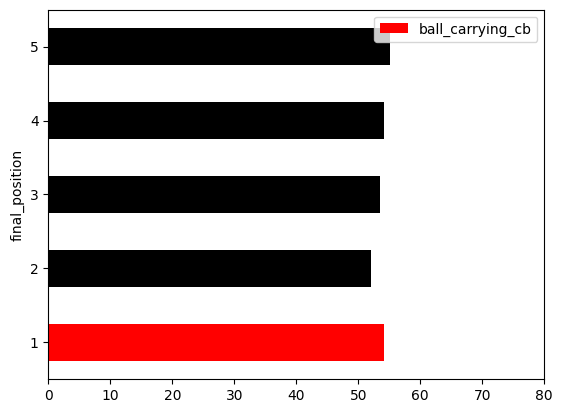

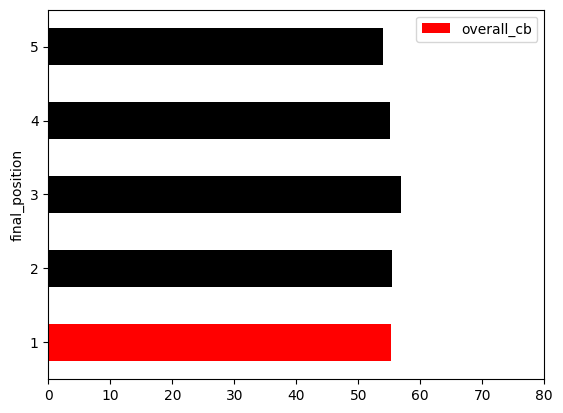

In [687]:
# Select only profiles scores
profiles_scores = all_final_5.iloc[:,76:-1].join(all_final_5['final_position'])
for col in profiles_scores.iloc[:,:-1].columns:
    profiles_scores.plot.barh(x='final_position', y=col, rot=0, color=['r','k','k','k','k']).set_xlim([0, 80])

<Axes: >

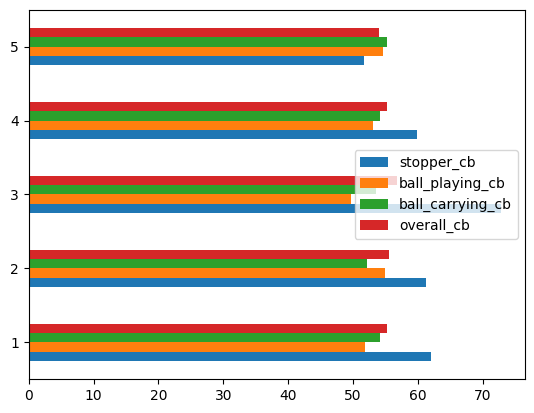

In [688]:
profiles_scores.iloc[:,:-1].plot.barh()